In [152]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
# from google.colab import drive

# drive.mount('/content/gdrive/')
# root_path = 'gdrive/My Drive/DA-1/'
root_path = ''

data = pd.read_csv(root_path+"Indian Earthquakes List Update_Magnitudes.csv", low_memory=False)
data = data.drop(['REFERENCE'],axis =1)
data = data.drop(['Sl. No.'],axis =1)
data = data.drop(['Mb'],axis =1)
data = data.drop(['Ms'],axis =1)
data = data.drop(['Ml'],axis =1)
data = data[data['Mw'].notna()]


In [153]:
# Pick a threshold that seem fit between [4, 5] inclusive.
# For Mw < T , label becomes 0 (no earthquake) and for Mw ≥ T becomes 1 (earthquake)
T = 4.5

In [154]:
# Convert values of Mw according to T for labels
data['label'] = data['Mw'].astype(str)
data['label']=pd.to_numeric(data['label'], downcast='float', errors='coerce')
data['label'] = (data['label'] >= T).astype(int)
data.columns = ['YEAR','MONTH', 'DATE', 'ORIGIN', 'Mw', 'LAT', 'LONG', 'DEPTH', 'INTENSITY', 'LOCATION', 'label']
data.head()

,YEAR,MONTH,DATE,ORIGIN,Mw,LAT,LONG,DEPTH,INTENSITY,LOCATION,label
0,-2474,NaN,NaN,NaN,7.5,71.0,24.00,0.0,NaN,NaN,1
1,-325,NaN,NaN,NaN,7.5,71.0,24.00,0.0,NaN,NaN,1
2,25,NaN,NaN,NaN,7.5,72.9,33.72,0.0,NaN,NaN,1
3,26,5,10.0,08.19.10.0,6.1397,17.3,80.10,NaN,NaN,NaN,1
4,26,5,10.0,08.19.10.0,6.1397,26.0,97.00,80.0,NaN,Myanmar,1


In [155]:
data['Mw']=pd.to_numeric(data['Mw'], downcast='float', errors='coerce')
data['DATE']=pd.to_numeric(data['DATE'], downcast='float', errors='coerce')
data['MONTH']=pd.to_numeric(data['MONTH'], downcast='float', errors='coerce')

In [156]:
data.shape[0]


50485

In [157]:
# Cleaning
outliers = data.isnull().sum()
print("Missing values: ")
print(outliers[outliers>0])

Missing values: 
MONTH           43
DATE            51
ORIGIN       31232
Mw               3
DEPTH         1257
INTENSITY    50472
LOCATION     41631
dtype: int64


In [158]:
data.Mw.median()
data.Mw.mean()

4.577815055847168

In [159]:
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# train, test = train_test_split(data, test_size=0.2)
features = ['DATE','MONTH','YEAR','LAT', 'LONG', 'DEPTH']
# features = ['DEPTH', 'INTENSITY']
X = data[features]
y=data.label
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.20, random_state=1)

In [160]:
# Missing Values
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(train_X))
imputed_X_valid = pd.DataFrame(my_imputer.transform(val_X))

In [161]:
dec_model=DecisionTreeRegressor(random_state=1)
dec_model.fit(imputed_X_train, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [162]:
from sklearn.metrics import mean_absolute_error

val_predictions = dec_model.predict(imputed_X_valid)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE when not specifying max_leaf_nodes: {:,.5f}".format(val_mae))
print(val_mae)

Validation MAE when not specifying max_leaf_nodes: 0.36496
0.36495988907596316


In [163]:
dec_model = DecisionTreeRegressor(max_leaf_nodes=100, random_state=1)
dec_model.fit(imputed_X_train, train_y)
val_predictions = dec_model.predict(imputed_X_valid)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE for best value of max_leaf_nodes: {:,.5f}".format(val_mae))
print(val_mae)

Validation MAE for best value of max_leaf_nodes: 0.38440
0.38440047094914936


140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
152


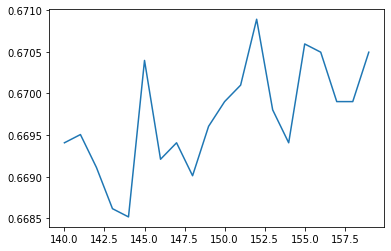

In [164]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(imputed_X_train)
val_X_scaled = scaler.transform(imputed_X_valid)
knn_scores = []
for k in range(140,160):
    print(k)
    # knn = KNeighborsClassifier(n_neighbors=3)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_X_scaled, train_y)
    knn_pred = knn.predict(val_X_scaled)
    knn_scores.append(accuracy_score(val_y, knn_pred))
print(range(140,160)[np.argmax(knn_scores)])
plt.plot(range(140,160),knn_scores)

[0.6927800336733684, 0.6988214321085471, 0.7003070218876895, 0.6980291175596712, 0.695553134594434]


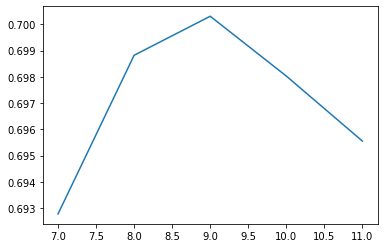

In [165]:
tree_scores = []
for d in [7,8,9,10,11]:
    tree = DecisionTreeClassifier(max_depth=d, random_state=1)
    tree.fit(imputed_X_train, train_y)    
    tree_pred = tree.predict(imputed_X_valid)
    tree_scores.append(accuracy_score(tree_pred, val_y))
print(tree_scores)
plt.plot([7,8,9,10,11],tree_scores)
plt.show()

(40388, 6)


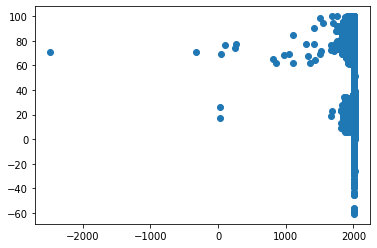

In [135]:
print(imputed_X_train.shape)
plt.scatter(imputed_X_train[2],imputed_X_train[3])

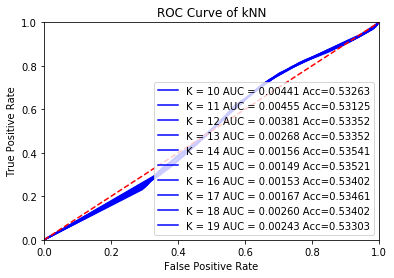

In [143]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# ROC with K as parameter in KNN
# knn = KNeighborsClassifier(n_neighbors = 10)
for k in range(10,20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_X_scaled, train_y)

    y_scores = knn.predict_proba(imputed_X_valid)
    y_preds = knn.predict(imputed_X_valid)
    accuracy = accuracy_score(val_y,y_preds)
    
    fpr, tpr, threshold = roc_curve(val_y, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.title('KNN Classifier on Indian Earthquakes')
    plt.plot(fpr, tpr, 'b', label = 'K = %d AUC = %0.5f Acc=%0.5f' % (k,abs(roc_auc-0.5),accuracy))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

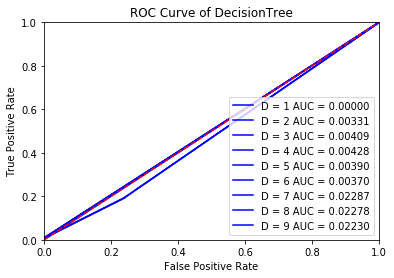

In [144]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# ROC with K as parameter in KNN
# knn = KNeighborsClassifier(n_neighbors = 10)
for d in range(1,10):
    tree = DecisionTreeClassifier(max_depth=d)
    tree.fit(train_X_scaled, train_y)

    y_scores = tree.predict_proba(imputed_X_valid)

    fpr, tpr, threshold = roc_curve(val_y, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.title('DecisionTree Classifier on Indian Earthquakes')
    plt.plot(fpr, tpr, 'b', label = 'D = %d Accuracy=%0.5f AUC = %0.5f' % (d,,abs(roc_auc-0.5)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of DecisionTree')
plt.show()

In [64]:
from sklearn.tree.export import export_text
tree_rules = export_text(tree, feature_names=features)
print(tree_rules)

|--- YEAR <= -0.15
|   |--- YEAR <= -0.37
|   |   |--- DEPTH <= -0.04
|   |   |   |--- YEAR <= -0.81
|   |   |   |   |--- YEAR <= -2.37
|   |   |   |   |   |--- LONG <= -0.48
|   |   |   |   |   |   |--- YEAR <= -3.43
|   |   |   |   |   |   |   |--- LONG <= -0.64
|   |   |   |   |   |   |   |   |--- LONG <= -0.74
|   |   |   |   |   |   |   |   |   |--- DATE <= 0.12
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- DATE >  0.12
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- LONG >  -0.74
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- LONG >  -0.64
|   |   |   |   |   |   |   |   |--- DATE <= -1.55
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- DATE >  -1.55
|   |   |   |   |   |   |   |   |   |--- YEAR <= -3.97
|   |   |   |   |   |   |   |   |   |   |--- YEAR <= -5.86
|   |   |   |   |   |   |   |   |   |   |   |--- class

Accuracy= 0.4666732692879073
MAE= 0.5333267307120927



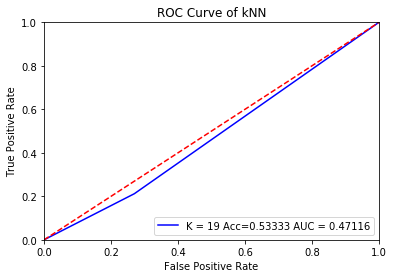

In [151]:
data['NEW_FEATURE'] = np.sqrt(data['LAT']**2 + data['LONG']**2)
# train_X,val_X, train_y, val_y =
X = data[['DATE','MONTH','YEAR','DEPTH','NEW_FEATURE']]
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.20, random_state=1)
new_imputer = SimpleImputer()
new_X_train = pd.DataFrame(new_imputer.fit_transform(train_X))
new_X_valid = pd.DataFrame(new_imputer.transform(val_X))

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(new_X_train)
val_X_scaled = scaler.transform(new_X_valid)

knn = DecisionTreeClassifier(max_depth=9,random_state=10)
knn.fit(train_X_scaled, train_y)
y_scores = knn.predict_proba(new_X_valid)
y_pred = knn.predict(new_X_valid)

print("Accuracy=",accuracy_score(val_y, y_pred))
print("MAE=",mean_absolute_error(val_y, y_pred))
fpr, tpr, threshold = roc_curve(val_y, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
print()
plt.title('KNN Classifier on Indian Earthquakes')
plt.plot(fpr, tpr, 'b', label = 'K = %d Acc=%0.5f AUC = %0.5f' % (k,mean_absolute_error(val_y, y_pred),roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()